Character learning has two components.  First, we need to learn the structure of the automaton representing the character; this remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [1]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd


import theano

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

/Users/jcosborn/.virtualenvs/mechlearn/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [ ]:
reload(jumpfinder)

In [3]:
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
# CHANGE GAME HERE
(game, startInputs, getx, gety) = games["mario"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
allTrials,minHold,maxHold = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)
(len(allTrials),minHold,maxHold)

(26, 1, 27)

Let's learn three linear-or-constant velocity models.

Move count:22 min hold:1
Jumping, record ground->rise from 0 to 10:[], prev DY0.0
Jumping, record rise->fall from 10 to 12 : enter rise, prev DY 0.0
Move count:24 min hold:1
Jumping, record ground->rise from 32 to 42:[3.0, 4.0, 4.0, 4.0, 1.0], prev DY1.0
Jumping, record rise->fall from 42 to 46 : enter rise, prev DY 0.0
Move count:27 min hold:1
Jumping, record ground->rise from 66 to 76:[3.0, 4.0, 5.0, 4.0, 3.0], prev DY3.0
Jumping, record rise->fall from 76 to 82 : enter rise, prev DY 0.0
Move count:29 min hold:1
Jumping, record ground->rise from 103 to 113:[4.0, 4.0, 4.0, 4.0, 2.0], prev DY2.0
Jumping, record rise->fall from 113 to 121 : enter rise, prev DY 0.0
Move count:33 min hold:1
Jumping, record ground->rise from 142 to 152:[4.0, 4.0, 4.0, 4.0, 4.0], prev DY4.0
Jumping, record rise->fall from 152 to 163 : enter rise, prev DY 0.0
Move count:36 min hold:1
Jumping, record ground->rise from 185 to 195:[5.0, 4.0, 4.0, 4.0, 2.0], prev DY2.0
Jumping, record rise->fall from 195 to 209 

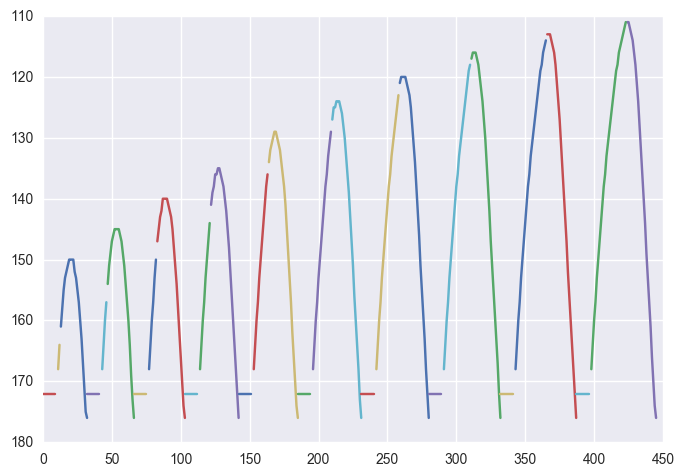

In [ ]:
mode_names = ["ground", "rise", "fall"]
modes = dict()
for m in mode_names:
    modes[m] = []

def record_run(modes, state, t, vbls, all_vbls):
    frame = pd.DataFrame(vbls)
    #print str(t)+":"+str(all_vbls)
    prev_vbls = dict(x=all_vbls["x"][t],
                     y=all_vbls["y"][t],
                     dx=all_vbls["dx"][t-1],
                     dy=all_vbls["dy"][t-1])
    modes[state].append((t, prev_vbls, frame))

t = 0
state_change_t = 0
trials = allTrials[0:6:2] + allTrials[6:-1:3]
all_vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
# Tweak the range and increment to get more precise/slower fitting.
for moves, stats in trials:
    state = "ground"
    vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
    start_t = t
    for i in range(10):
        vbls["x"].append(stats.x.allVals[0])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[0])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(0.)
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(0.)
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
        t += 1
    print "Move count:"+str(len(moves))+" min hold:"+str(minHold)
    for i, m in enumerate(moves):
        if state == "ground" and m & jumpButton:
            print "Jumping, record ground->rise from "+str(state_change_t)+" to "+str(t)+":"+str(all_vbls["dy"][state_change_t-5:state_change_t])+", prev DY"+str(all_vbls["dy"][state_change_t-1])
            record_run(modes, 
                       state,
                       state_change_t,
                       vbls,
                       all_vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "rise"
        elif state == "rise" and not (m & jumpButton) and i >= minHold:
            print "Jumping, record rise->fall from "+str(state_change_t)+" to "+str(t)+" : enter rise, prev DY "+str(all_vbls["dy"][state_change_t-1])
            #print "DYs:"+str(all_vbls["dy"][state_change_t-5:state_change_t])
            record_run(modes,
                       state,
                       state_change_t,
                       vbls,
                       all_vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "fall"
        t += 1
        vbls["x"].append(stats.x.allVals[i+1])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[i+1])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(stats.x.allVals[i+1] - stats.x.allVals[i])
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(stats.y.allVals[i+1] - stats.y.allVals[i])
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
    #print "Landed, record "+state+"->ground from "+str(state_change_t)+" to "+str(t)
    record_run(modes, 
               state,
               state_change_t,
               vbls,
               all_vbls)
    state_change_t = t
    

for m in modes:
    #print m
    for (run_start, prev_vbls, run_vbls) in modes[m]:
        #print str(run_start)+".."+str(run_start+len(run_vbls["y"]))
        #print "PVs:"+str(prev_vbls)
        plt.plot(run_vbls["t"]+run_start, run_vbls["y"])


plt.gca().invert_yaxis()
plt.show()


In [ ]:
with pm.Model() as model:
    var_order = ["dx","dy"]
    accs = dict()
    consts = dict()
    sigs = dict()
    prev_weights = dict()
    for m in modes:
        # TODO: change back to per-ha-variable vars, they sampled much much faster for some reason.
        sigs[m] = pm.HalfCauchy(m+"_sigma",beta=10,testval=1.,shape=2)
        accs[m] = pm.Normal(m+"_acc",mu=0,sd=20,testval=0.,shape=(2,1))
        consts[m] = pm.Normal(m+"_const",mu=0.,sd=20,shape=2)
        prev_weights[m] = pm.Normal(m+"_weights",mu=1.,shape=(2,2))
        
        # TODO: pack all trials at once into variable shapes
        for (start, prev_vbls, vbls) in modes[m]:
            #Investigate whether I should do something special to handle the quantized values?
            # this should be 2x1 broadcasted out
            prev_vels = pm.Normal(m+"_"+str(start)+"_prev",
                                  shape=2,
                                  mu=[prev_vbls["dx"],prev_vbls["dy"]],
                                  observed=[[prev_vbls["dx"],prev_vbls["dy"]]])
            times = np.array(vbls["t"])[:,None]
            vals = np.array([vbls["dx"],vbls["dy"]])
            weights = prev_weights[m]
            muPrev = weights.dot(prev_vels.T)
            #TODO: this expression should also have a Theano.clip() with a learnable parameter for each variable min/max.
            muInit = (consts[m] + muPrev.T)
            mu = muInit.T + accs[m].dot(times.T)
            # Lots of transpose dancing here, I'm not totally sure it's right... is it slowing things down?
            lik = pm.Normal(m+"_"+str(start),
                            mu=mu.T,
                            sd=sigs[m],
                            shape=(2,20),
                            observed=vals.T)
    print "Find start"
    start = dict()
    #start = pm.approx_hessian(model.test_point)
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    trace = pm.sample(10000, step, njobs=3, progressbar=True)
    print "Done!"

Applied log-transform to fall_sigma and added transformed fall_sigma_log_ to model.
Applied log-transform to rise_sigma and added transformed rise_sigma_log_ to model.
Applied log-transform to ground_sigma and added transformed ground_sigma_log_ to model.


Find start
{}
Set up step method
Start sampling


100%|██████████| 10000/10000 [10:58<00:00, 15.19it/s]


In [ ]:
with model:
    trace = pm.sample(10000, pm.Metropolis(), progressbar=True)

In [16]:
pm.stats.summary(trace[1000:-1:10])


fall_dx_acc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.000           0.000            0.000            [-0.000, -0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.000         -0.000         -0.000         -0.000         -0.000


fall_dx_const:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


fall_weights_dx:

  Mean             SD               MC Error         95% HPD interval


In [ ]:
plt.figure(figsize=(6, 6))
pm.traceplot(trace[1000:-1:10],varnames=["fall_dy_acc","fall_dy_resetp","fall_dy_resetval","rise_dy_acc","rise_dy_resetp","rise_dy_resetval"])
plt.tight_layout();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124c4d150>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x15c7a1450>]], dtype=object)

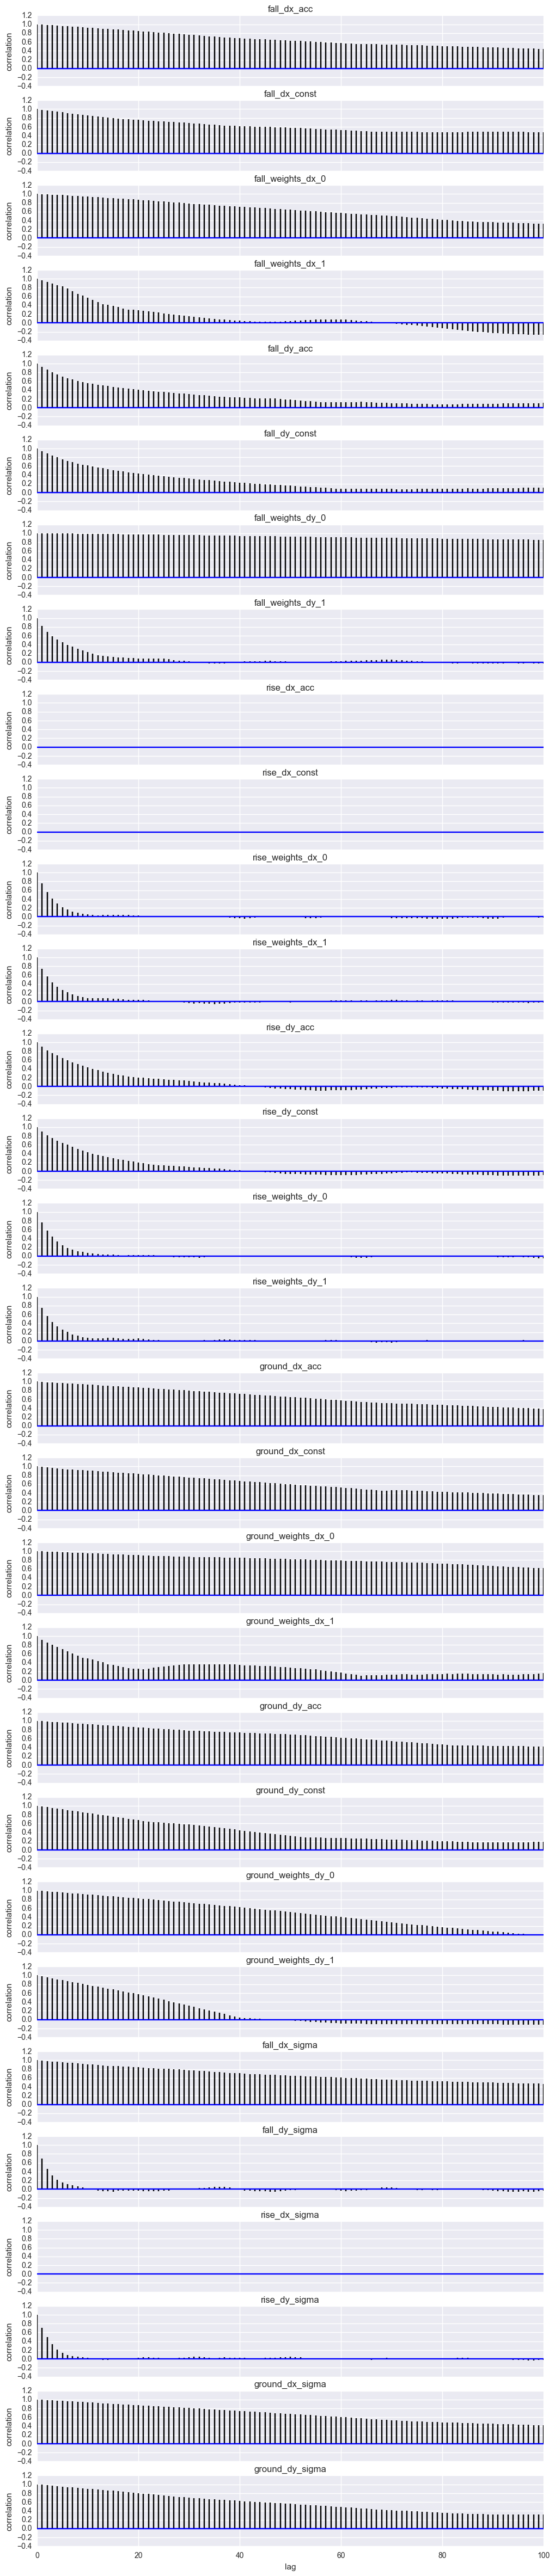

In [17]:
pm.autocorrplot(trace[1000:])

In [ ]:
from jumpfinder import marioModel,DT
import copy

samples = 400
m = copy.deepcopy(marioModel)

realYs = []
for (_moves,stats) in trials:
    realYs = realYs + stats.y.allVals

sample = 0
for rand_trace in np.random.randint(1000, len(trace), samples):
    sample += 1
    t = trace[rand_trace]
    m.params["gravity"].update(t["fall_dy_acc"]/(DT*DT),True)
    m.params["risingGravity"].update(t["rise_dy_acc"]/(DT*DT),True)
    m.params["minButtonDuration"].update(minHold*DT,True)
    m.params["maxButtonDuration"].update(maxHold*DT,True)
    
    # set the jumpStartSpeed to the expression rise_dy_const + rise_weights_dy*(dx,dy).
    #  be sure that these use the pre-transition values during transitions!
    m.params["jumpStartSpeed"] = ("+", 
                                  t["rise_dy_const"]/DT,
                                  ("*", t["rise_weights_dy"][0]/DT, ("x", 1)),
                                  ("*", t["rise_weights_dy"][1]/DT, ("y", 1)))
    m.params["jumpToFallStartSpeed"] = ("+", 
                                  t["fall_dy_const"]/DT,
                                  ("*", t["fall_weights_dy"][0]/DT, ("x", 1)),
                                  ("*", t["fall_weights_dy"][1]/DT, ("y", 1)))

    # then do jump trials with horizontal speed and make sure we learn the right weights.
    # then try to learn the clipping for earlyOutClipVel and other discrete velocity updates
    modelYs = []
    for (moves,stats) in trials:
        val = m.makeValuation({("x", 0): stats.x.allVals[0], ("y", 0): stats.y.allVals[0]})
        modelYs.append(val.variables[("y",0)])
        for mi,move in enumerate(moves):
            m.step(val, 
                   DT, 
                   set(["jump"] if move & jumpButton else []), 
                   set([("bottom", "ground")] if abs(val.variables[("y", 0)] - stats.y.allVals[0]) < 0.1 and mi >= 5 else []))
            modelYs.append(val.variables[("y",0)])
    plt.plot(modelYs,"x-")
plt.plot(realYs,"o")
plt.gca().set_ylim((100,180))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
pm.stats.dic(model=model,trace=trace)
